# Jonathan Halverson
# Friday, October 27, 2017
# Logistic regression from scratch in TF

$ J(w_i) = \sum_i y_i \ln p_i + (1-y_i)\ln (1-p_i) $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('halverson')
%matplotlib inline

In [2]:
from sklearn.datasets import make_moons

In [3]:
X, y = make_moons(noise=0.1, random_state=42)

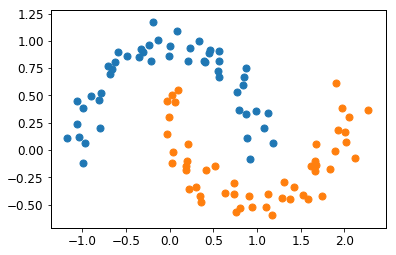

In [4]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#### With regularization

In [6]:
pline = Pipeline([('std_sc', StandardScaler()), ('lr', LogisticRegression())])
param_grid = {'lr__C':np.logspace(-2, 2, num=10), 'lr__penalty':['l1', 'l2']}
grid_search = GridSearchCV(pline, param_grid, cv=10, scoring='accuracy', refit=True)
grid_search.fit(X, y).score(X, y)

0.88

In [7]:
grid_search.best_params_

{'lr__C': 0.077426368268112694, 'lr__penalty': 'l1'}

In [8]:
grid_search.best_estimator_.named_steps['lr'].intercept_, grid_search.best_estimator_.named_steps['lr'].coef_

(array([ 0.]), array([[ 0.30561792, -1.02784975]]))

#### Without regularization and standardization

In [9]:
lr = LogisticRegression(C=1e6).fit(X, y)
lr.score(X, y)

0.85999999999999999

In [10]:
lr.intercept_, lr.coef_

(array([ 0.60883873]), array([[ 1.22028034, -4.99852444]]))

#### With standardization

In [11]:
X_std = StandardScaler().fit_transform(X)
lr = LogisticRegression().fit(X_std, y)
lr.score(X_std, y)

0.87

In [12]:
lr.intercept_, lr.coef_

(array([-0.00093552]), array([[ 0.97181293, -2.01357067]]))

### Brute force optimization

In [13]:
from scipy.special import expit

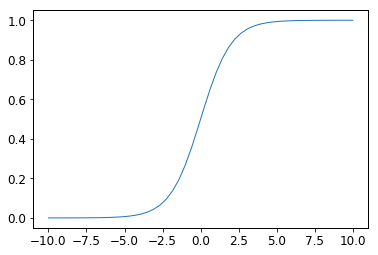

In [14]:
plt.plot(np.linspace(-10, 10), expit(np.linspace(-10, 10)))

In [15]:
expit(2.0), np.exp(2.0) / (1 + np.exp(2.0))

(0.88079707797788231, 0.88079707797788243)

In [16]:
np.log(2.7182)

0.99996989653910984

In [17]:
J_min = -1e6
best_values = None
for i in xrange(10000):
     intercept = 2 * (np.random.random() - 0.5)
     w1 = 4 * (np.random.random() - 0.5)
     w2 = 15 * (np.random.random() - 0.5)
     omega = np.dot(X, np.array([w1, w2])) + intercept
     p = expit(omega)
     J = y * np.log(p) + (1 - y) * np.log(1 - p)
     if J.sum() > J_min:
          J_min = J.sum()
          best_values = intercept, w1, w2

In [18]:
best_values

(0.6518142706049808, 1.1665585748154568, -5.196032547698286)

### Logistic regression using gradient descent 

In [19]:
learning_rate = 0.01
epochs = 100000

In [20]:
theta = np.array([0.5, -0.5, 0.25])
X_bias = np.c_[np.ones((X.shape[0], 1)), X]

In [21]:
for epoch in xrange(epochs):
     errors = expit(np.dot(X_bias, theta)) - y
     gradients = (1.0 / X_bias.shape[0]) * np.dot(X_bias.T, errors)
     theta = theta - learning_rate * gradients

In [22]:
theta

array([ 0.60871047,  1.22028252, -4.99805092])

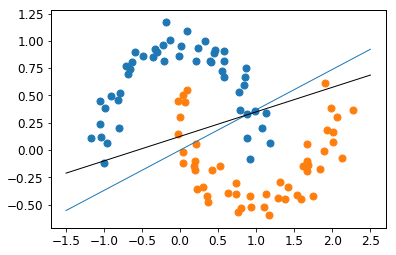

In [23]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
w1 = 0.61595971
w2 = -1.68557807
x = np.linspace(-1.5, 2.5)
plt.plot(x, 0.62158356 * x / 1.68389095)
plt.plot(x, -(best_values[0] + best_values[1] * x) / best_values[2], 'k-')
#plt.ylim(-2, 2)

#### From scratch implementation

In [24]:
import tensorflow as tf

In [25]:
tf.reset_default_graph()

In [26]:
features = X.copy()
labels = y.copy()

In [27]:
#features = np.c_[np.ones((features.shape[0], 1)), StandardScaler().fit_transform(features)]
#features[0:5]

In [28]:
epochs = 50000
learning_rate = 0.01

Look for scipy sigmoid function:

In [29]:
m = X_bias.shape[0]
Xr = tf.constant(X_bias, name="X", dtype=tf.float32)
yr = tf.constant(labels.reshape(-1, 1), name="y", dtype=tf.float32)
theta = tf.Variable(tf.random_uniform([3, 1], -1.0, 1.0), name='theta')

p = tf.exp(tf.matmul(Xr, theta)) / (1.0 + tf.exp(tf.matmul(Xr, theta)))
errors = p - yr
gradients = (1.0 / m) * tf.matmul(tf.transpose(Xr), errors)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

In [30]:
with tf.Session() as sess:
     sess.run(init)
     for epoch in range(epochs):
          #if (epoch % 500 == 0):
           #    print('Epoch', epoch, "MSE=", J.eval())
          sess.run(training_op)
     best_theta = theta.eval()

In [31]:
best_theta

array([[ 0.60013533],
       [ 1.2197628 ],
       [-4.96458578]], dtype=float32)

#### Compute the gradient using TF

In [32]:
tf.reset_default_graph()

In [40]:
m = X_bias.shape[0]
Xr = tf.constant(X_bias, name="X", dtype=tf.float32)
yr = tf.constant(labels.reshape(-1, 1), name="y", dtype=tf.float32)
ones = tf.constant(np.ones(m), name='ones', dtype=tf.float32)
theta = tf.Variable(tf.random_uniform([3, 1], -1.0, 1.0), name='theta')

p = tf.exp(tf.matmul(Xr, theta)) / (1.0 + tf.exp(tf.matmul(Xr, theta)))
J = tf.reduce_mean( -(1.0 / m) * tf.matmul(yr, tf.log(p)) + tf.matmul((ones - yr), tf.log(ones - p)), name="J")
gradients = tf.gradients(J, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

ValueError: Dimensions must be equal, but are 1 and 100 for 'MatMul_11' (op: 'MatMul') with input shapes: [100,1], [100,1].